# eSPA models

In this notebook, we will describe the various possibilities of using eSPA models through `entlearn`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from entlearn.models.eSPA import eSPA
from entlearn.utils.synthetic_data import make_worm
np.random.seed(42)

For simplicity, we will make a single train-test split of a generated dataset.

In [2]:
T = 250
D = 100

X, y = make_worm(D, T, 10, rng=np.random.default_rng(42))
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

## eSPA

The eSPA problem is a minimization problem of the following loss functional:

$\begin{align}
\mathcal{L}_\text{eSPA} = &\sum_{t,k,d=1}^{T,K,D} W_d \Gamma_{k,t} (X_{d,t}-C_{d,k})^2 \\
&+ \varepsilon_W \sum_{d=1}^D W_d \log(W_d) \\
&- \varepsilon_C \sum_{m,t=1}^{M,T} \Pi_{m,t} \sum_{k=1}^K \Gamma_{k,t} \log \left(\Lambda_{m,k}\right),
\end{align}$

where :

- $\Gamma \in [0,1]^{K \times T}$, and  $\sum_{k=1}^K \Gamma_{k,t} = 1$ for all $t$ 
- $\Lambda \in [0,1]^{M \times K}$, and  $\sum_{m=1}^M \Lambda_{k,t} = 1$ for all $t$ 
- $W \in [0,1]^D$, and  $\sum_{d=1}^D W_d = 1$ 

The hyperparameters to be selected are: 
- $\varepsilon_W$ (regularization for the entropy term)
- $\varepsilon_C$ (regularization for the classification term)
- $K$ (number of clusters)

## Fitting a single model

A single eSPA model can be fit using the `eSPA_single` object. This can be useful if annealing is not desired.

Note how running the cell multiple times can lead to quite variable results. This is the effect of the initialization. Exploring various initial points and selecting the best performing one (i.e., using annealing) leads to more rebust performance.

In [3]:
from entlearn.models.eSPA import eSPA_single

m = eSPA_single(
    K=3,
    epsC=1e-2,
    epsW=1e-2
)

m.fit(X_train,y_train)
print(f"Performance on the training set: {m.score(X_train, y_train):.2f}, and on the test set {m.score(X_test, y_test):.2f}")

Performance on the training set: 0.63, and on the test set 0.44


## Fitting with annealing
As discussed above, in most cases, it is preferable to explore a range of possible starting points. 
This can be achieved by using an `eSPA` model and specifying the desired amount of annealings.

In [4]:
m = eSPA(
    K = 3,
    epsC = 1e-1,
    epsW = 5e-2,
    anneals=20,
)

m.fit(X_train, y_train)
print(f"Performance on the training set: {m.score(X_train, y_train):.2f}, and on the test set {m.score(X_test, y_test):.2f}")

Performance on the training set: 0.96, and on the test set 0.92


We can inspect the evolution of the loss value over the amount of iterations performed, by looking at the `losses_` property of the `fitted_model_`

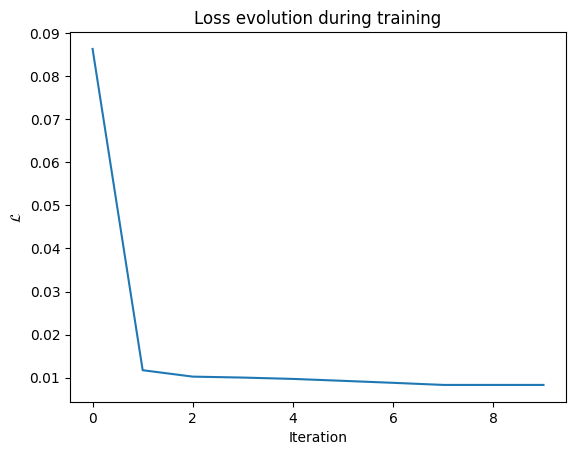

In [5]:
plt.plot(m.fitted_model_.losses_)
plt.xlabel("Iteration")
plt.ylabel(r"$\mathcal{L}$")
plt.title("Loss evolution during training")
plt.show()

eSPA outputs probability distributions for each given data pointm which can be obtained with the `predict_proba` method.

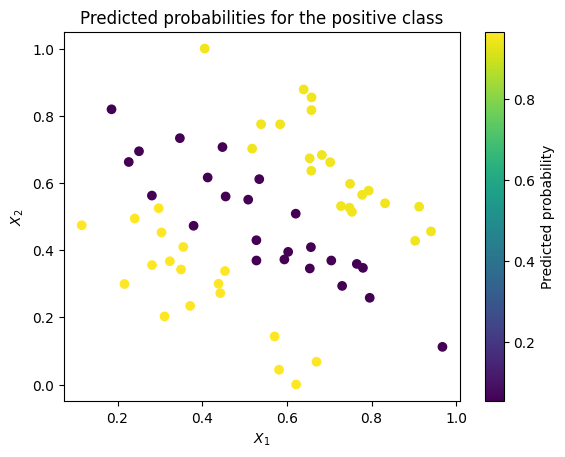

In [6]:
probas = m.predict_proba(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=probas[:,1])
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Predicted probabilities for the positive class")
plt.colorbar(label='Predicted probability')
plt.show()


As with other `sklearn` classifiers, we can also obtain a single most probable class for each data point, using the `predict` method.

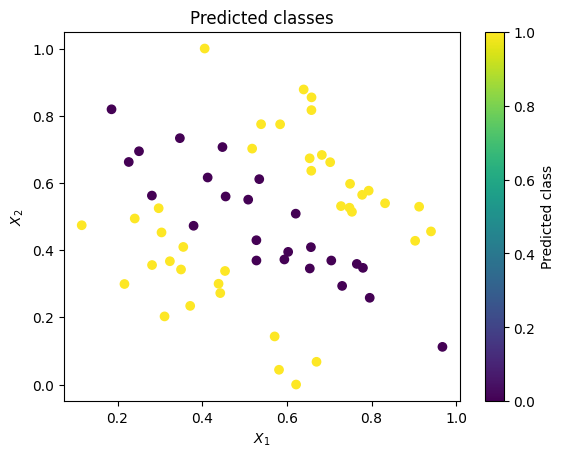

In [7]:
preds = m.predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=preds)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Predicted classes")
plt.colorbar(label='Predicted class')
plt.show()

## Anatomy of an eSPA model

One of the favorable property of an eSPA model is its interpretability. Each parameter plays a clear role and thus provides information about the data.

### Centroids
The centroids can be accessed from the `C_` property of a fitted model, and are collected in a `D` by `K` matrix.
We can overlay them on the original data to see their location.

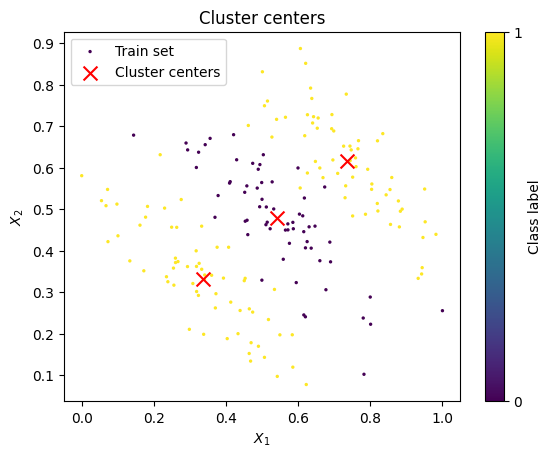

In [8]:
model = m.fitted_model_

plt.scatter(X_train[:,0], X_train[:,1], c=y_train, s=2, label='Train set')
plt.scatter(model.C_[0,:], model.C_[1,:], label='Cluster centers', marker='x', color='red', s=100)
plt.xlabel(r"$X_1$")
plt.ylabel(r"$X_2$")
plt.title("Cluster centers")
plt.colorbar(label='Class label', ticks=np.unique(y_train))
plt.legend()
plt.show()

The parameter $\Lambda$ represents the conditional label probability for each box.

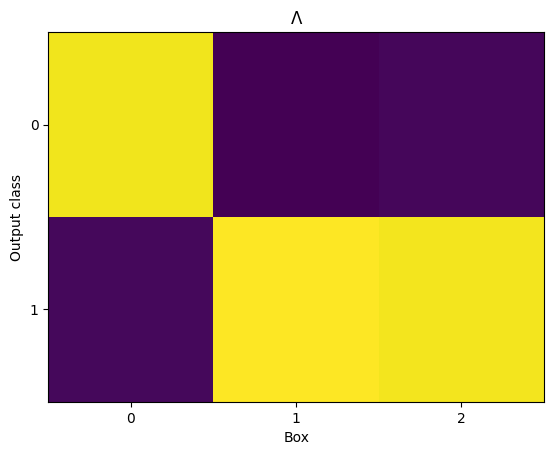

In [9]:
plt.imshow(model.L_, aspect='auto', interpolation='none')
plt.xticks(np.arange(0, model.K))
plt.yticks(np.arange(0, 2))
plt.ylabel("Output class")
plt.xlabel("Box")
plt.title(r"$\Lambda$")
plt.show()

The parameter $W$ is a stochastic vector collecting the feature importance probability distribution over the input dimensions.

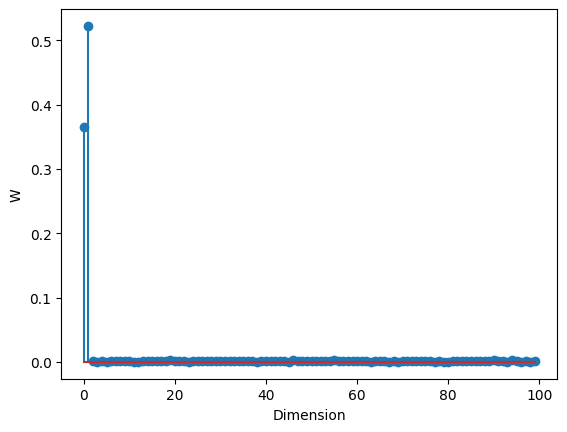

In [10]:
plt.stem(model.W_)
plt.ylabel("W")
plt.xlabel("Dimension")
plt.show()